In [1]:
%reload_ext cairo_jupyter

Vec2(x=0, y=0)
Matrix2D(values=[[1, 0, 0], [0, 1, 0], [0, 0, 1]])
Vec2(y=4, x=4)
Matrix2D(values=[[1, 0, 0], [0, 1, 0], [23, 23, 1]])


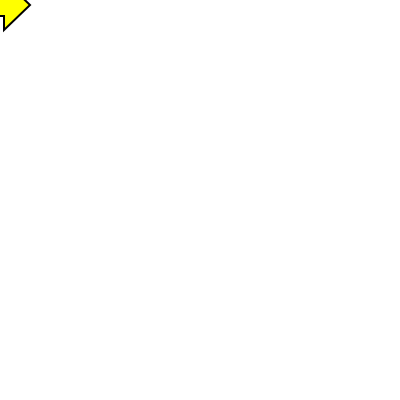

Path(closed=True, elements=[('move_to', Vec2(y=-15.91485139224611, x=13.517303916192828)), ('line_to', Vec2(x=25.485768355758964, y=2.5447222474358444)), ('line_to', Vec2(x=5.348051657924106, y=15.601228908780719)), ('line_to', Vec2(x=12.964347210375283, y=27.34823031585105)), ('line_to', Vec2(x=-22.452040317846723, y=20.515990972063356)), ('line_to', Vec2(x=-14.236708334093205, y=-14.60534613797157)), ('line_to', Vec2(y=-2.8583447309012353, x=-6.620412781642028))])


In [2]:
import cairo
import math

from collections import namedtuple

def class_repr(self):
    """
    Default class repr that outputs the content of a class.
    """
    members = ', '.join({f'{k}={v}'
                         for k, v in 
                         self.__dict__.items()})
    return f'{self.__class__.__name__}({members})'


class Vec2:
    def __init__(self, x, y):
        self.x = x
        self.y = y
        
    @property
    def xy(self):
        return (self.x, self.y)

    def __iter__(self):
        return iter(list((self.x, self.y)))
    
    def cross(self):
        """
        https://blog.demofox.org/2020/02/09/a-fun-2d-rotation-matrix-derivation/
        
        > ...there is this thing that people call the “2d cross product”
        > which is not really a cross product but if you have a 2d vector,
        > it will give you a vector perpendicular to that vector.
        """
        return Vec2(-self.y, self.x)
    
    def add(self, v):
        return Vec2(self.x + v.x, self.y + v.y)
    
    def multiply_matrix(self, m):
        #print(m.values)
        col = m.get_column(0)
        new_x = self.x * col[0] + self.y * col[1] + col[2]
        
        col = m.get_column(1)
        new_y = self.x * col[0] + self.y * col[1] + col[2]
        
        return Vec2(new_x, new_y)
        #values = [*self, 0]
        #for value in values:
        #    print(value)
        
        
    __repr__ = class_repr
        
#Vec2 = namedtuple("Vec2", "x y")
# Matrix2D = namedtuple("Matrix", "a b c\
#                                  d e f\
#                                  g h i")

IDENTITY_MATRIX_2D = [
    [1, 0, 0],
    [0, 1, 0],
    [0, 0, 1],  # This is always 0, 0, 1
]

class Matrix2D:
    def __init__(self, *values):
        if not values:
            self.values = list(IDENTITY_MATRIX_2D)
        else:
            if isinstance(values[0], Vec2):
                self.values = [
                    [1, 0, 0],
                    [0, 1, 0],
                    [values[0].x, values[0].y, 1],
                ]
            else:
                self.values = values
          
    def translate(self, x, y):
        m = Matrix2D(*self.values)
        m.values[0][2] = x
        m.values[1][2] = y
        return m
    
    def shear(self, x=0, y=0):
        self.values[1][0] = y
        self.values[0][1] = x
        return self
        
    @classmethod
    def Rotate(cls, radians):
        cos_theta = math.cos(radians)
        sin_theta = math.sin(radians)
        
        return Matrix2D(
            [cos_theta, sin_theta, 0],
            [sin_theta, -cos_theta, 0],
            [0, 0, 1]
        )
    
    def get_column(self, c):
        return [
            self.values[0][c],
            self.values[1][c],
            self.values[2][c]
        ]
    
    __repr__ = class_repr


v = Vec2(0, 0)
m = Matrix2D()

print(v)
print(m)

print(v.add(Vec2(4, 4)))


#m.rotate(0.1)
print(Matrix2D(Vec2(23, 23)))

surface = cairo.ImageSurface(cairo.FORMAT_ARGB32, 400, 400)
context = cairo.Context(surface)

class Path:
    def __init__(self):
        self.elements = []
        self.closed = False
        
    def line_to(self, *args):
        self.elements.append(("line_to", Vec2(*args)))
        
    def move_to(self, *args):
        self.elements.append(("move_to", Vec2(*args)))
        
    def close(self):
        self.closed = True
        
    def transform(self, m):
        p = Path()
        for t, v in self.elements:
            pos = v.multiply_matrix(m)
            if t == "line_to":
                p.line_to(pos.x, pos.y)
            elif t == "move_to":
                p.move_to(pos.x, pos.y)
            else:
                raise NotImplemented(t)
            if self.closed:
                p.close()
        return p
            
    def draw(self, ctx):
        for t, v in self.elements:
            if t == "line_to":
                ctx.line_to(v.x, v.y)
            elif t == "move_to":
                ctx.move_to(v.x, v.y)
            else:
                raise NotImplemented(t)
        if self.closed:
            ctx.close_path()
            
            
    __repr__ = class_repr


def arrow(x, y, width, height, a, b):
    p = Path()
    p.move_to(x, y + b)
    p.line_to(x, y + height - b)
    p.line_to(x + a, y + height - b)
    p.line_to(x + a, y + height)
    p.line_to(x + width, y + height/2)
    p.line_to(x + a, y)
    p.line_to(x + a, y + b)
    p.close()
    return p
 
def draw(path):
    context.set_source_rgb(1, 1, 1)
    #context.scale(10, 10)
    context.paint()
    context.set_source_rgba(1, 1, 0, 1)
    path.draw(context)
    context.fill_preserve()
    context.set_source_rgba(0, 0, 0, 1)
    context.stroke()
    
    display(surface)


path = arrow(100, 10, 50, 50, 24, 14)
#draw(path)

#draw(path.transform(Matrix2D().shear(.25, .25)))

#draw(path.transform(Matrix2D().shear(1.125, -.25)))


path = arrow(-20, -20, 50, 50, 24, 14)
draw(path)
#draw(path.transform(Matrix2D(Vec2(10, .1))))
#draw(path.transform(Matrix2D().translate(100, 0)))
#draw(path.transform(Matrix2D().shear(.25, -.25)))
path2 = path.transform(Matrix2D.Rotate(-10).translate(40, 40))

print(path2)

#draw(path)

#Matrix2D.Rotate(.1)